# Problem 1a

In [581]:
## Setup
# load packages
import numpy as np
import csv
import random
import math

# load data
with open("Concrete_Data_Yeh.csv") as fp:
    f = csv.reader(fp, delimiter=",", quotechar='"')
    conc_dat = np.array([row for row in f])

# add intercept term to features
conc_dat = np.concatenate((np.ones((conc_dat.shape[0], 1)), conc_dat), axis=1)
conc_dat[0,0] = "(intercept)"

# split out header
header = conc_dat[0,:]

In [582]:
## Functions
def solve_beta(data):
    """Estimates beta coefficients via numpy."""
  
    # separate into features vs. outputs

    header = data[0]
    y_ind = np.where(header == "csMPa")[0][0]

    X = np.array(data[1:, :y_ind], dtype="float")
    Y = np.array(data[1:,y_ind], dtype="float")

    # solve for (X^T*X)^-1
    XtX_inv = np.linalg.inv(np.dot(X.T, X))

    # solve for beta
    beta = np.dot(np.dot(XtX_inv, X.T), Y)
    return beta, X, Y

beta_est, _, _ = solve_beta(conc_dat)
print(beta_est)

[-2.33312136e+01  1.19804334e-01  1.03865809e-01  8.79343215e-02 -1.49918419e-01  2.92224595e-01  1.80862148e-02  2.01903511e-02  1.14222068e-01]


# Problem 1b

In [583]:
## Split into training/validation sets (75/25)
# random.seed(12345)

# make vector of indices
inds = [i + 1 for i in list(range(len(conc_dat)-1))]

# shuffle randomly
random.shuffle(inds)

# take first 75%/last 25%
train_inds = inds[:math.floor(0.75*len(conc_dat))]
val_inds = inds[math.floor(0.75*len(conc_dat)):]
train = np.array([conc_dat[i] for i in train_inds])
val = np.array([conc_dat[i] for i in val_inds])

# add header to training datasets
train = np.vstack((header, train))

## Build alternative models (first 7/8/9 columns)
## Fit models to training data 
m1, X1, Y1 = solve_beta(train[:, np.array([0,1,2,3,4,5,6,9])])
m2, X2, Y2 = solve_beta(train[:, np.array([0,1,2,3,4,5,6,7,9])])
m3, X3, Y3 = solve_beta(train[:, np.array([0,1,2,3,4,5,6,7,8,9])])

## Compute MSE with test data

y_ind = np.where(header == "csMPa")[0][0]
Y_val = np.array(val[:,y_ind], dtype="float")
val = np.array(val[0:], dtype="float")
val = np.concatenate((np.ones((val.shape[0], 1)), val), axis=1)

mse1 = np.mean((np.dot(val[:, np.array([0,1,2,3,4,5,6])], m1) - Y_val)**2)
mse2 = np.mean((np.dot(val[:, np.array([0,1,2,3,4,5,6,7])], m2) - Y_val)**2)
mse3 = np.mean((np.dot(val[:, np.array([0,1,2,3,4,5,6,7,8])], m3) - Y_val)**2)

print(mse1)
print(mse2)
print(mse3)

4455.744130504338
4409.277485791199
21105.67733051163


The models with more variables included do not always have better validation-set error than simpler models. 

# Problem 2

In [584]:
# Setup
import torch
import torch.nn as nn
import torch.optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd

# load MNIST data
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform = transforms.ToTensor())
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform = transforms.ToTensor())

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [585]:
# load feature extractor
# load weights from feature_extractor_weights.pth
import Encoder
model = Encoder.extractor()
model.load_state_dict(torch.load("feature_extractor_weights.pth"))

<All keys matched successfully>

In [586]:
# define logistic regression function
def log_reg(X, W, b):
    y_hat = torch.matmul(X, W) + b
    return(y_hat)

# define gradient function
def grad(X, y, t):
    grad_out = torch.matmul((y - t).T, X)
    return(grad_out.T)

def grad_b(X, y, t):
    grad_out = torch.matmul((y - t).T, torch.ones(X.shape[0]).unsqueeze(1))
    return(grad_out.T)

In [587]:
# set up initial weights/bias
b = torch.randn(1,10)
W = torch.randn(256,10)
lr = 0.05
print(b)

ls = torch.empty(0)
j = 1
# for minibatch in batches
for imgs, labs in trainloader:
    
    # extract latent features
    h = model.forward(imgs)

    # do logistic regression
    # take softmax of the output
    # find best fit label
    y_hat = torch.sigmoid(log_reg(h, W, b))
    denom = torch.sum(torch.exp(y_hat), dim=1, keepdim=True)
    y_hat_soft = torch.exp(y_hat)/denom
    
    # flatten to avoid infinite loss values
    y_hat_soft = torch.maximum(torch.tensor(10**(-17)), y_hat_soft)
    y_hat_soft = torch.minimum(torch.tensor(1 - 10**(-7)), y_hat_soft)
    
    # encode truth matrix
    t = torch.zeros(h.shape[0], 10)
    for i in range(0, h.shape[0]):
        lab = labs[i]
        t[i, lab] = 1
    
    # calculate loss (lecture 3, slide 41)
    loss = -torch.sum(t*torch.log(y_hat_soft), dim=1, keepdim=True)
    ls = torch.cat((ls, torch.mean(loss).unsqueeze(0)), dim=0)
    
    # iterate: stochastic gradient descent
    W = W - lr*grad(h, y_hat, t)
    b = b - lr*grad_b(h, y_hat, t)
    
    #j = j + 1
    #if j > 15:
        #break ## for debugging only!

tensor([[ 0.2561, -0.8042, -0.4516,  0.9748, -0.4168,  1.5231,  0.1783,  1.5721,
          0.5429, -0.6381]])


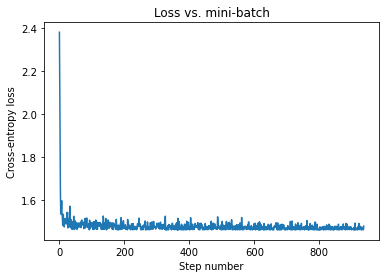

In [588]:
# plot loss vs. mini-batch
import matplotlib.pyplot as plt
import math
inds = range(len(ls))

plt.plot(inds, ls.detach().numpy(), linestyle="-")
plt.xlabel("Step number")
plt.ylabel("Cross-entropy loss")
plt.title("Loss vs. mini-batch")
plt.show()

# Problem 3

(see homework 1_p3.pdf for derivation)

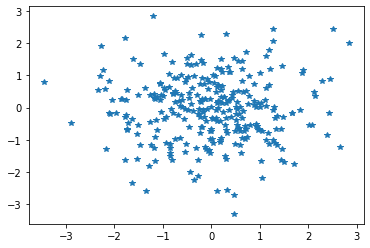

In [589]:
# setup
import torch
import math
import matplotlib.pyplot as plt

# pull variables
U1 = torch.rand(300,1)
U2 = torch.rand(300, 1)

# set R, theta
theta = 2*math.pi*U1
R = (-2*torch.log(U2))**(1/2)

# set X, Y
x = R*torch.cos(theta)
y = R*torch.sin(theta)

# plot x,y coordinates
plt.plot(x,y,"*")
plt.show()